#An R-Based Analysis of a Moving Average Crossover Strategy vs. Buy-and-Hold: Evidence from Several Major Tech Stocks

This project looks at whether a simple moving average (SMA) crossover strategy can outperform a buy-and-hold approach for big tech stocks. The idea is straightforward: stay invested when the 50-day SMA is above the 200-day SMA, square off and step out of the market when it isn’t. Daily stock data for major technology companies was collected from Yahoo Finance (yfinance), covering the full year of 2024. I defined a function called analyse_stock_strategy which did all the analysis and returned the required result to reduce repetition. For each stock, cumulative returns were plotted to show how $1 would grow under buy-and-hold versus the SMA strategy. The study then compared both approaches using common performance metrics like total return, annualized volatility, Sharpe ratio, and maximum drawdown. Results showed that while buy-and-hold often delivered higher raw returns, the SMA strategy sometimes reduced downside risk and drawdowns. The project highlights how simple trading stratrgies such as SMA can change risk-return tradeoffs, although they don't necessarily outperform.

## Installing all the required packages

I have used quantmod to fetch historical financial data from Yahoo Finance. Then, dplyr is used to structure this data and calculate daily returns. Finally, the TTR package provides the necessary technical indicators, specifically the Simple Moving Average (SMA), to implement the trading strategy.

In [ ]:
install.packages(c("quantmod", "dplyr", "TTR"), quiet = TRUE)
library(quantmod)
library(dplyr)
library(TTR)

##Defining the Analyse Stock Strategy function

1. Here, I have defined a function beforhand named analyse_stock_strategy. It helps to reduce redundancy in code. The analyze stock strategy function performs the entire analysis from the research paper for any stock ticker you give it.

2. Firstly, it takes a stock symbol, like "AAPL", as input and downloads its daily price history for the year 2024 from Yahoo Finance. Next, it calculates the day by day performance of two different strategies: the simple buy and hold method and the 50 day versus 200 day moving average crossover strategy.

3. Finally, it produces two key outputs for you to see. It draws a line chart that visually compares how a one dollar investment would have grown under each strategy, and it prints a summary table with key performance and risk metrics like the final return, max drawdown, and Sharpe ratio.

In [ ]:
analyze_stock_strategy <- function(ticker)
{

  #data and parameters (quantmod)
  start_date <- "2024-01-01"
  end_date <- "2024-12-31"

  stock_data_xts <- getSymbols(ticker, src = "yahoo", from = start_date, to = end_date, auto.assign = FALSE) #auto.assign = false because it tells the function to return the data as a variable we can use
  stock_df <- data.frame(date = index(stock_data_xts), coredata(stock_data_xts)) #convert the xts timeseries object into a standard r dataframe as it is easier to work with
  colnames(stock_df)[7] <- "Adjusted" #renaming for clarity

  #calculations (using dplyr and ttr)
  #the logic is identical to the paper's description
  results <- stock_df %>%
    arrange(date) %>% #ensure data is in chronical order
    mutate(daily_return = (Adjusted - lag(Adjusted)) / lag(Adjusted)) %>% #daily % return
    mutate(ma_fast = SMA(Adjusted, n = 50),ma_slow = SMA(Adjusted, n = 200)) %>% #50 and 200d sma
    filter(!is.na(daily_return)) %>% #removing first row with nan return
    mutate(signal = ifelse(ma_fast > ma_slow, 1, 0),signal = ifelse(is.na(signal), 0, signal)) %>% #signal 1 if 50d>200d else 0 (out of market)
    mutate(strategy_return = lag(signal, 1) * daily_return) %>% #lag by one day to prevent look ahead bias
    mutate(strategy_return = ifelse(is.na(strategy_return), 0, strategy_return)) %>%  #clean first na strategy return
    mutate(buy_hold_cum = cumprod(1 + daily_return),strategy_cum = cumprod(1 + strategy_return)) #cum growth for sma nd buy and sell

  #plotting graph
  options(repr.plot.width = 18, repr.plot.height = 9)
  plot(x = results$date,y = results$buy_hold_cum,type = "l", col = "blue", main = paste("Buy-and-Hold vs. MA Crossover for", toupper(ticker)), xlab = "Date", ylab = "Growth of $1", ylim = range(c(results$buy_hold_cum, results$strategy_cum))) # Ensure y-axis fits both lines)

  #ma line graph
  lines(x = results$date, y = results$strategy_cum, col = "red")

  #graph name
  legend("topleft", legend = c("Buy and Hold", "MA Crossover"), col = c("blue", "red"),lty = 1) # Line type


#performance metrics

#final cumulative returns
final_buy_hold_ret <- last(results$buy_hold_cum)
final_strategy_ret <- last(results$strategy_cum)

#daily returns
daily_return_bh <- results$daily_return
daily_return_strategy <- results$strategy_return

#annualized volatility (std dev of daily returns * sqrt(252))
vol_bh <- sd(daily_return_bh, na.rm = TRUE) * sqrt(252)
vol_strategy <- sd(daily_return_strategy, na.rm = TRUE) * sqrt(252)

#max drawdown
cum_bh <- results$buy_hold_cum
cum_strategy <- results$strategy_cum

max_dd_bh <- min(cum_bh / cummax(cum_bh) - 1)
max_dd_strategy <- min(cum_strategy / cummax(cum_strategy) - 1)

#annualized sharpe ratio
sharpe_bh <- (mean(daily_return_bh, na.rm = TRUE) / sd(daily_return_bh, na.rm = TRUE)) * sqrt(252)
sharpe_strategy <- (mean(daily_return_strategy, na.rm = TRUE) / sd(daily_return_strategy, na.rm = TRUE)) * sqrt(252)

#creating a data frame for the metrics table
metrics_df <- data.frame(
  Metric = c("Final Cumulative Return (Buy & Hold)","Final Cumulative Return (MA Strategy)","Max Drawdown (Buy & Hold)","Max Drawdown (MA Strategy)","Annualized Volatility (Buy & Hold)","Annualized Volatility (MA Strategy)","Annualized Sharpe Ratio (Buy & Hold)","Annualized Sharpe Ratio (MA Strategy)"),
  Value = c(round(final_buy_hold_ret, 4),round(final_strategy_ret, 4),round(max_dd_bh, 4),round(max_dd_strategy, 4),round(vol_bh, 4),round(vol_strategy, 4),round(sharpe_bh, 4),round(sharpe_strategy, 4))
)

#displaying results
cat("\n\n--- Performance Metrics for", toupper(ticker), "---\n")
print(metrics_df)
}


#Analysing all the stocks individually

The research paper used Apple (AAPL), Meta (META), Microsoft (MSFT), Netfilx (NFLX) AND Nvidia (NVDA). We will now use our defined function analyse_stock_strategy to analyse all these stocks.

## Stock 1: AAPL



--- Performance Metrics for AAPL ---
                                 Metric   Value
1  Final Cumulative Return (Buy & Hold)  1.3652
2 Final Cumulative Return (MA Strategy)  1.0893
3             Max Drawdown (Buy & Hold) -0.1535
4            Max Drawdown (MA Strategy) -0.0612
5    Annualized Volatility (Buy & Hold)  0.2245
6   Annualized Volatility (MA Strategy)  0.0734
7  Annualized Sharpe Ratio (Buy & Hold)  1.5099
8 Annualized Sharpe Ratio (MA Strategy)  1.2107


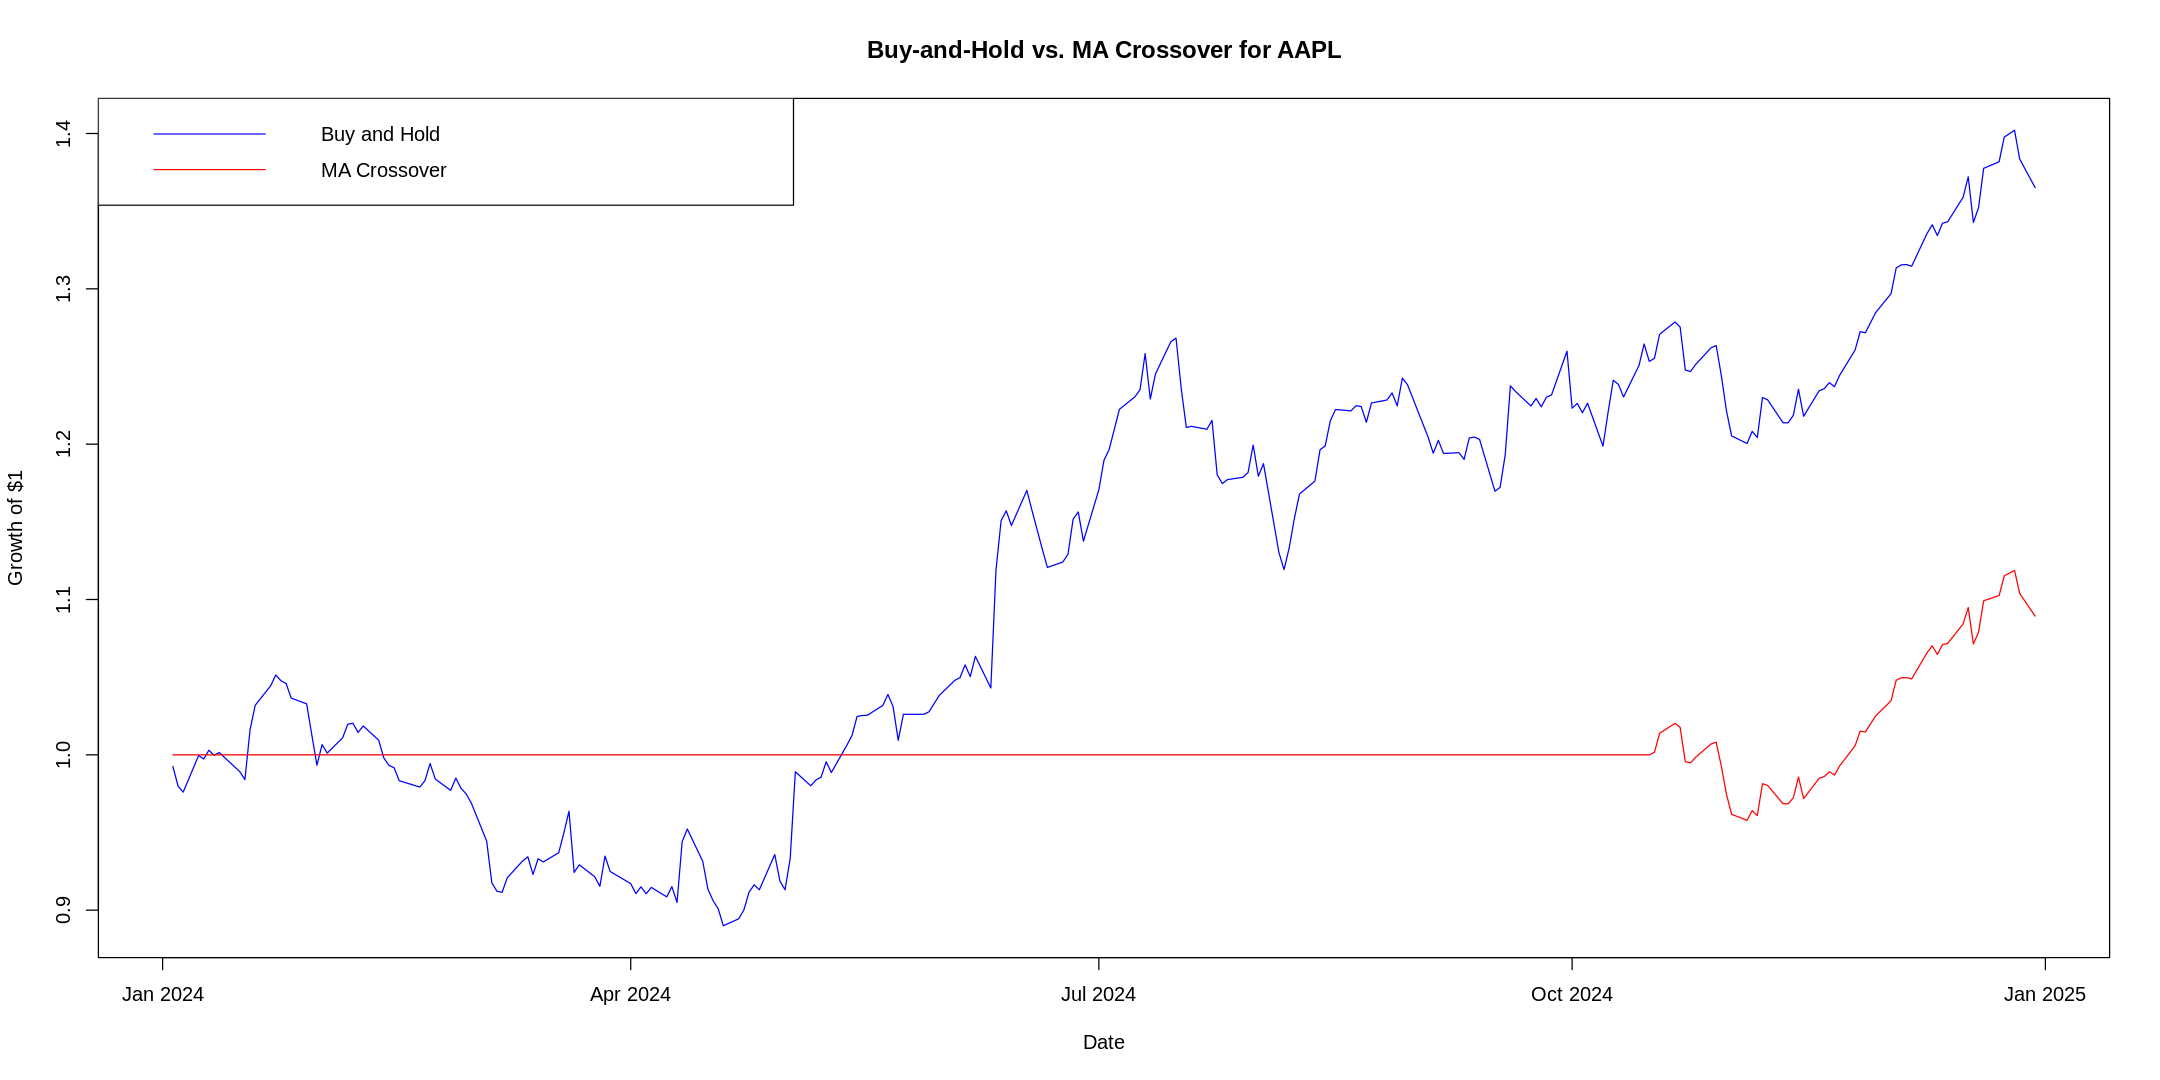

In [ ]:
analyze_stock_strategy("AAPL")

## Stock 2: META



--- Performance Metrics for META ---
                                 Metric   Value
1  Final Cumulative Return (Buy & Hold)  1.7139
2 Final Cumulative Return (MA Strategy)  1.0259
3             Max Drawdown (Buy & Hold) -0.1843
4            Max Drawdown (MA Strategy) -0.0742
5    Annualized Volatility (Buy & Hold)  0.3653
6   Annualized Volatility (MA Strategy)  0.1227
7  Annualized Sharpe Ratio (Buy & Hold)  1.6648
8 Annualized Sharpe Ratio (MA Strategy)  0.2712


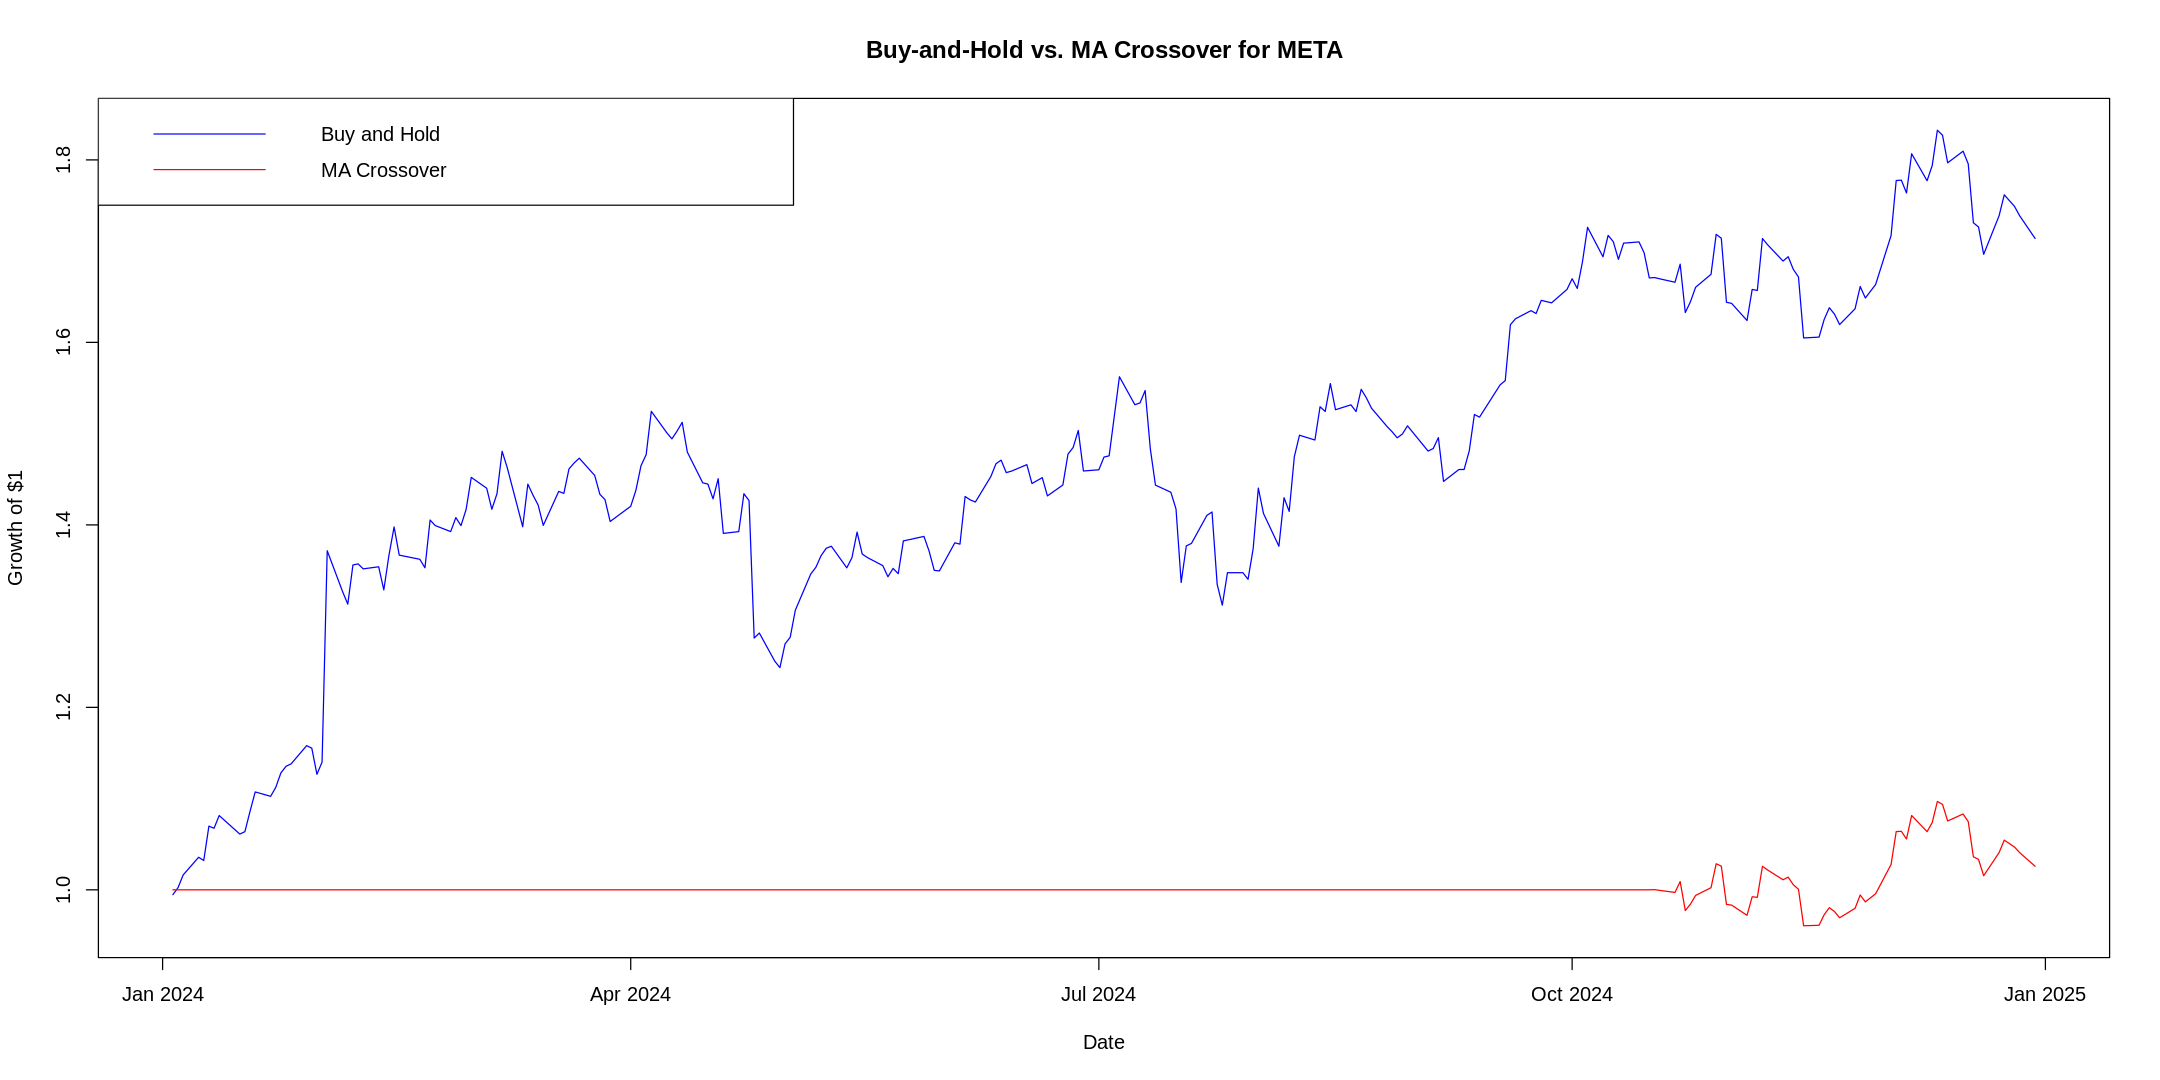

In [ ]:
analyze_stock_strategy("META")

## Stock 3: MSFT



--- Performance Metrics for MSFT ---
                                 Metric   Value
1  Final Cumulative Return (Buy & Hold)  1.1541
2 Final Cumulative Return (MA Strategy)  0.9648
3             Max Drawdown (Buy & Hold) -0.1549
4            Max Drawdown (MA Strategy) -0.0718
5    Annualized Volatility (Buy & Hold)  0.1997
6   Annualized Volatility (MA Strategy)  0.0968
7  Annualized Sharpe Ratio (Buy & Hold)  0.8236
8 Annualized Sharpe Ratio (MA Strategy) -0.3237


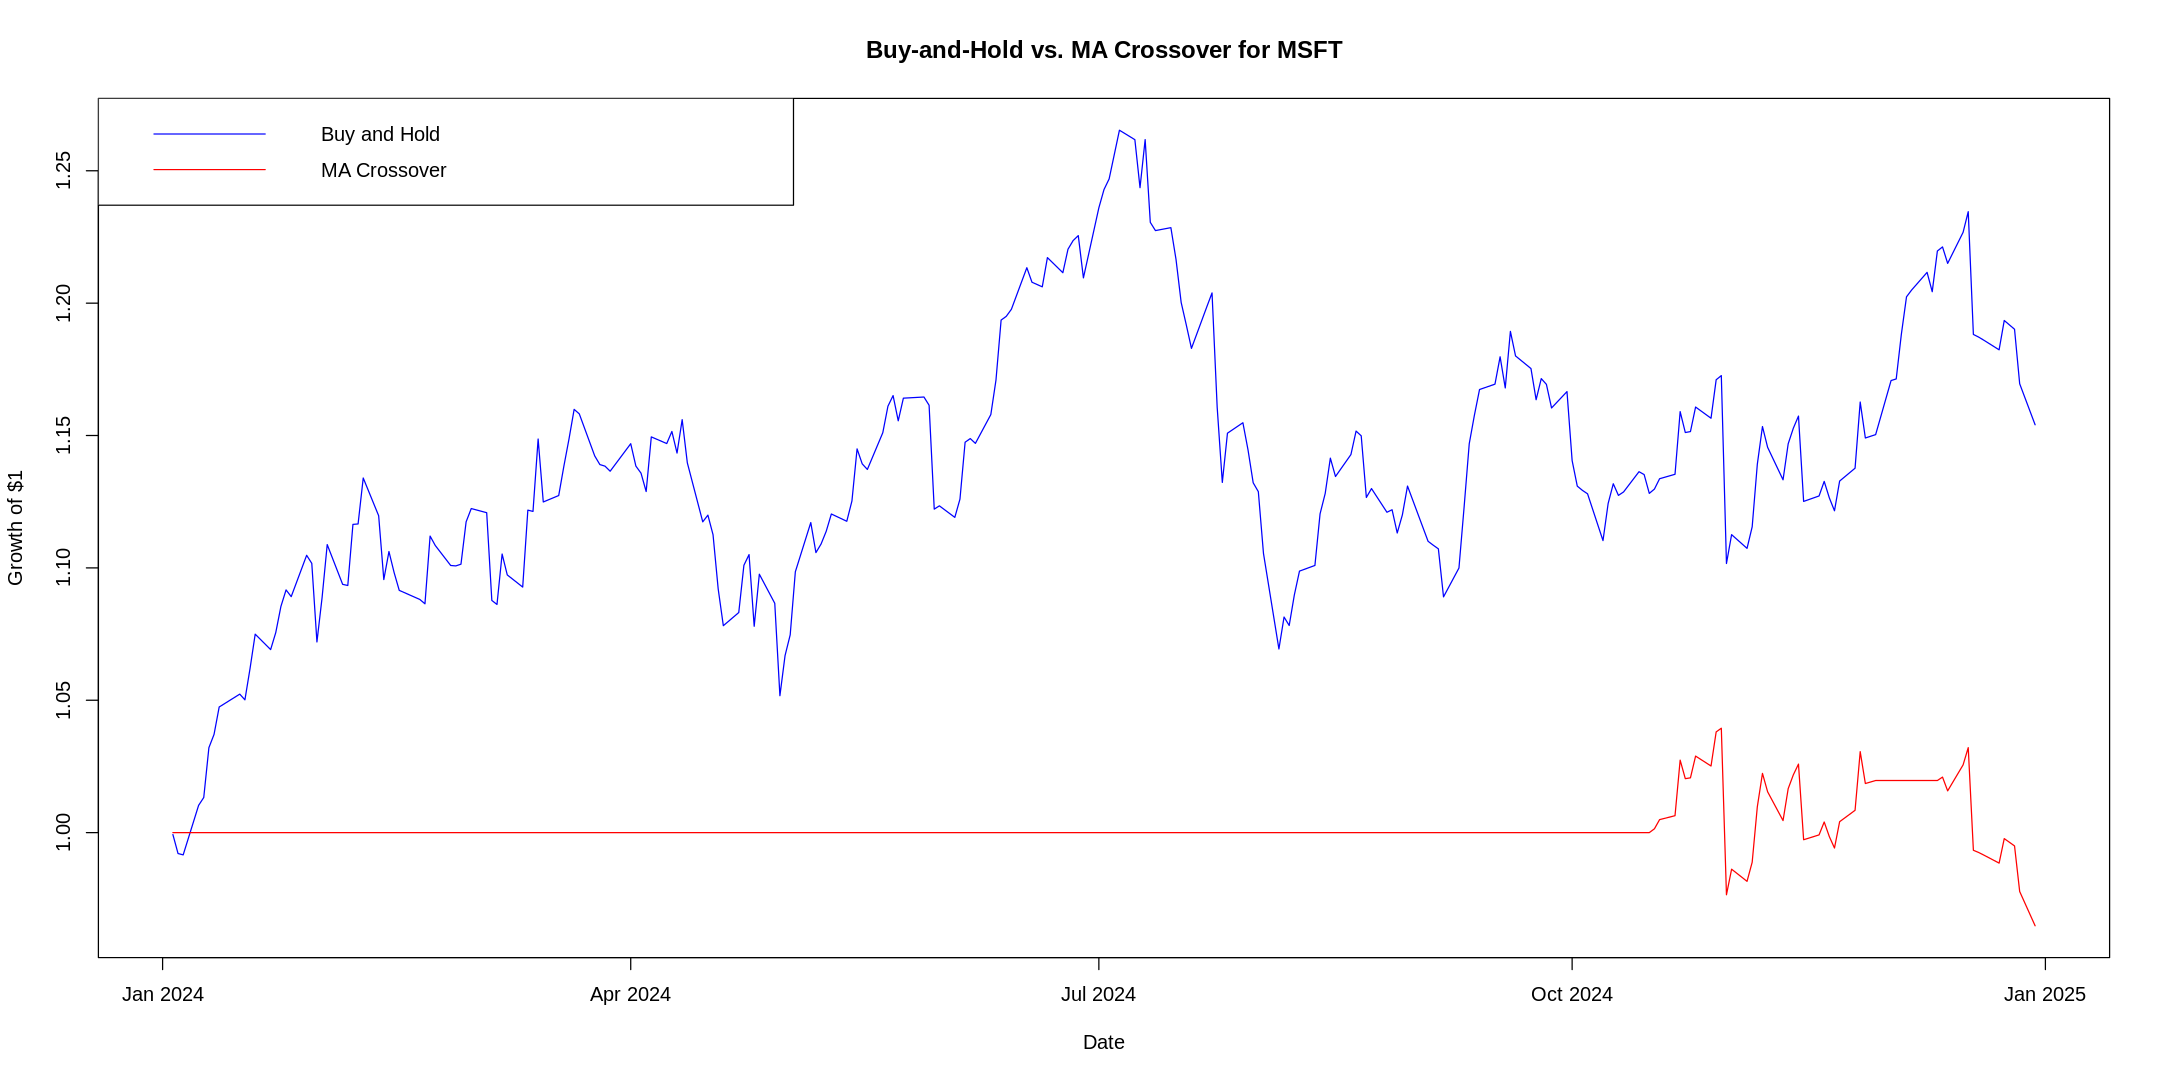

In [ ]:
analyze_stock_strategy("MSFT")

## Stock 4: NFLX



--- Performance Metrics for NFLX ---
                                 Metric   Value
1  Final Cumulative Return (Buy & Hold)  1.9219
2 Final Cumulative Return (MA Strategy)  1.2827
3             Max Drawdown (Buy & Hold) -0.1345
4            Max Drawdown (MA Strategy) -0.0502
5    Annualized Volatility (Buy & Hold)  0.2954
6   Annualized Volatility (MA Strategy)  0.1533
7  Annualized Sharpe Ratio (Buy & Hold)  2.3777
8 Annualized Sharpe Ratio (MA Strategy)  1.7109


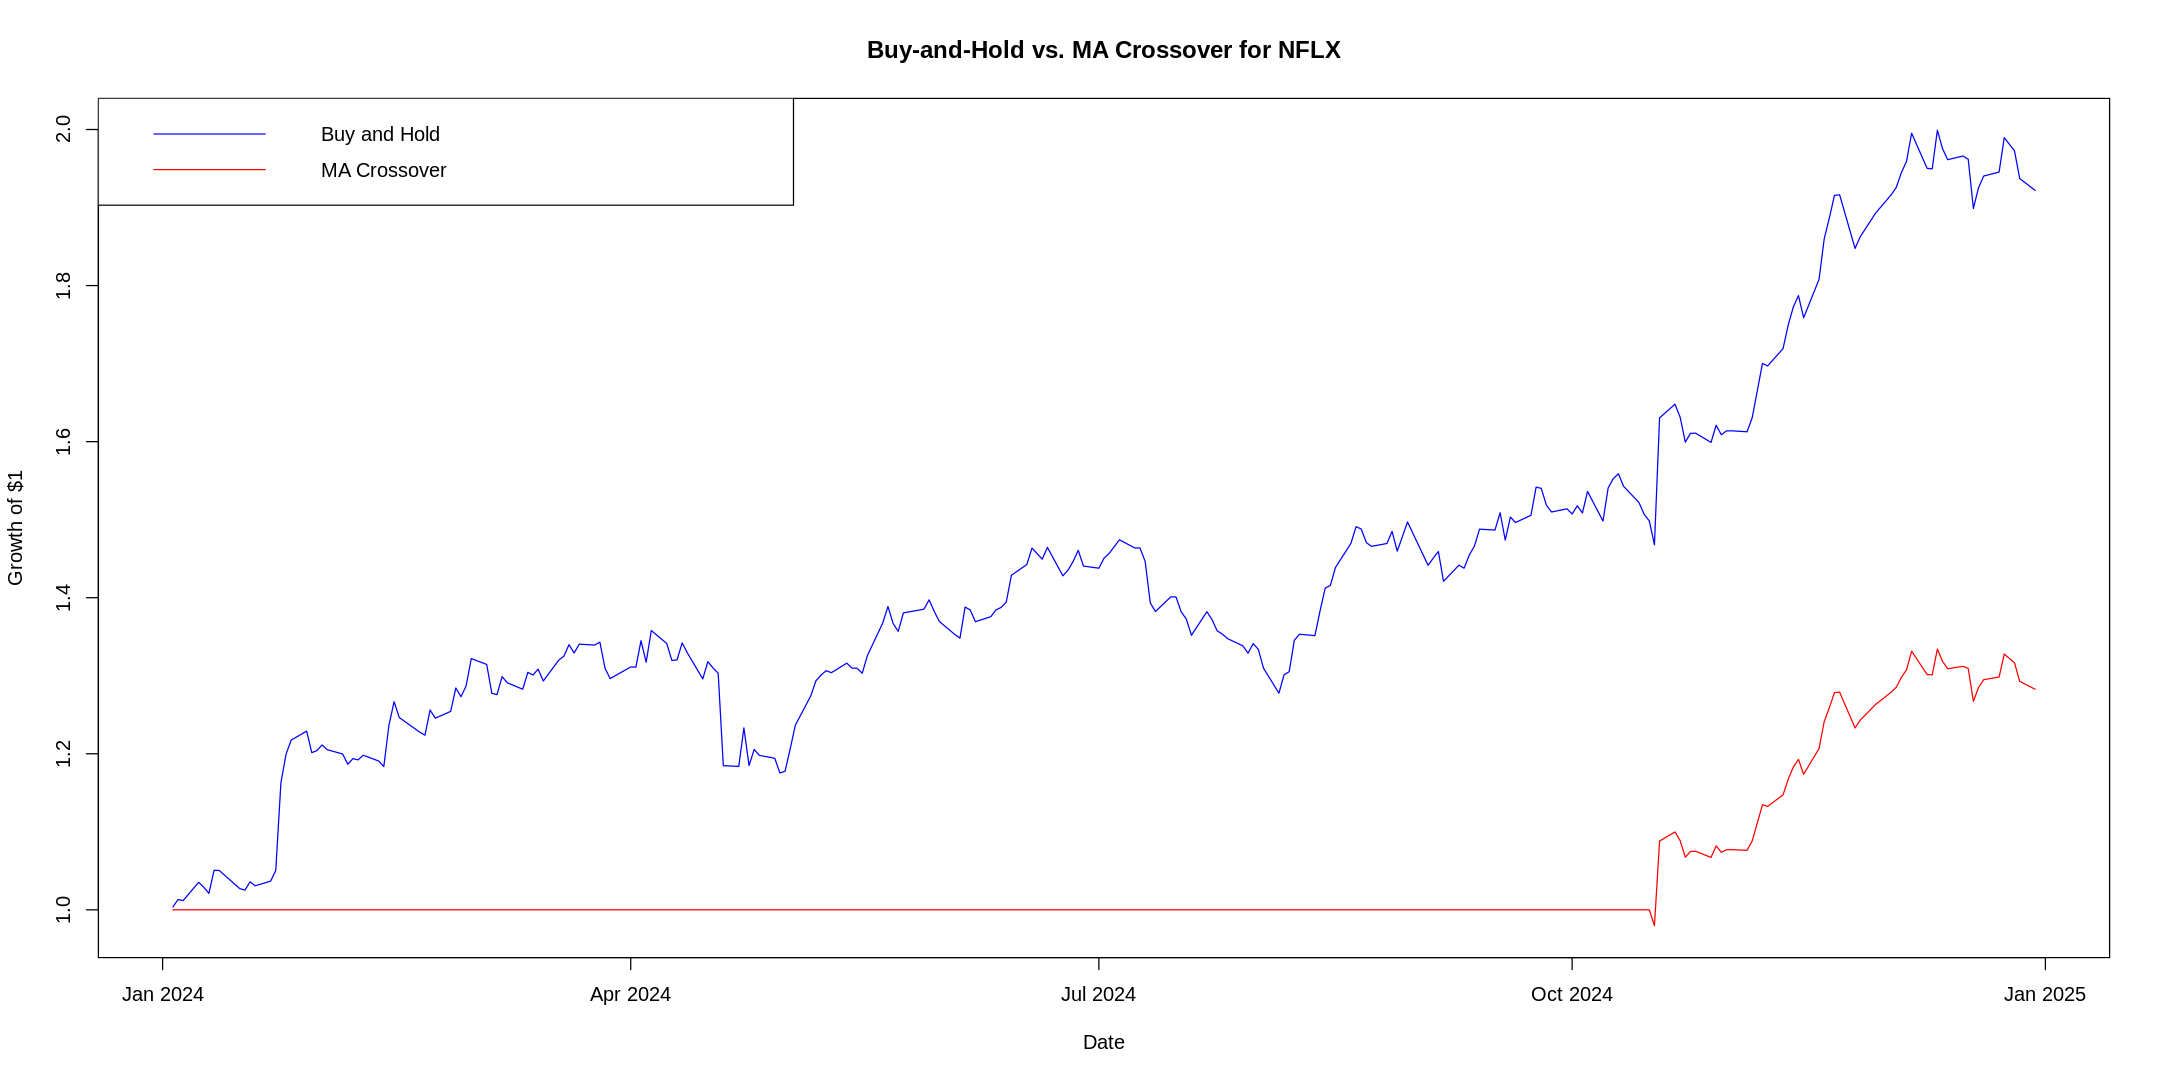

In [ ]:
analyze_stock_strategy("NFLX")

## Stock 5: NVDA



--- Performance Metrics for NVDA ---
                                 Metric   Value
1  Final Cumulative Return (Buy & Hold)  2.8552
2 Final Cumulative Return (MA Strategy)  1.0131
3             Max Drawdown (Buy & Hold) -0.2705
4            Max Drawdown (MA Strategy) -0.1341
5    Annualized Volatility (Buy & Hold)  0.5254
6   Annualized Volatility (MA Strategy)  0.1590
7  Annualized Sharpe Ratio (Buy & Hold)  2.2760
8 Annualized Sharpe Ratio (MA Strategy)  0.1616


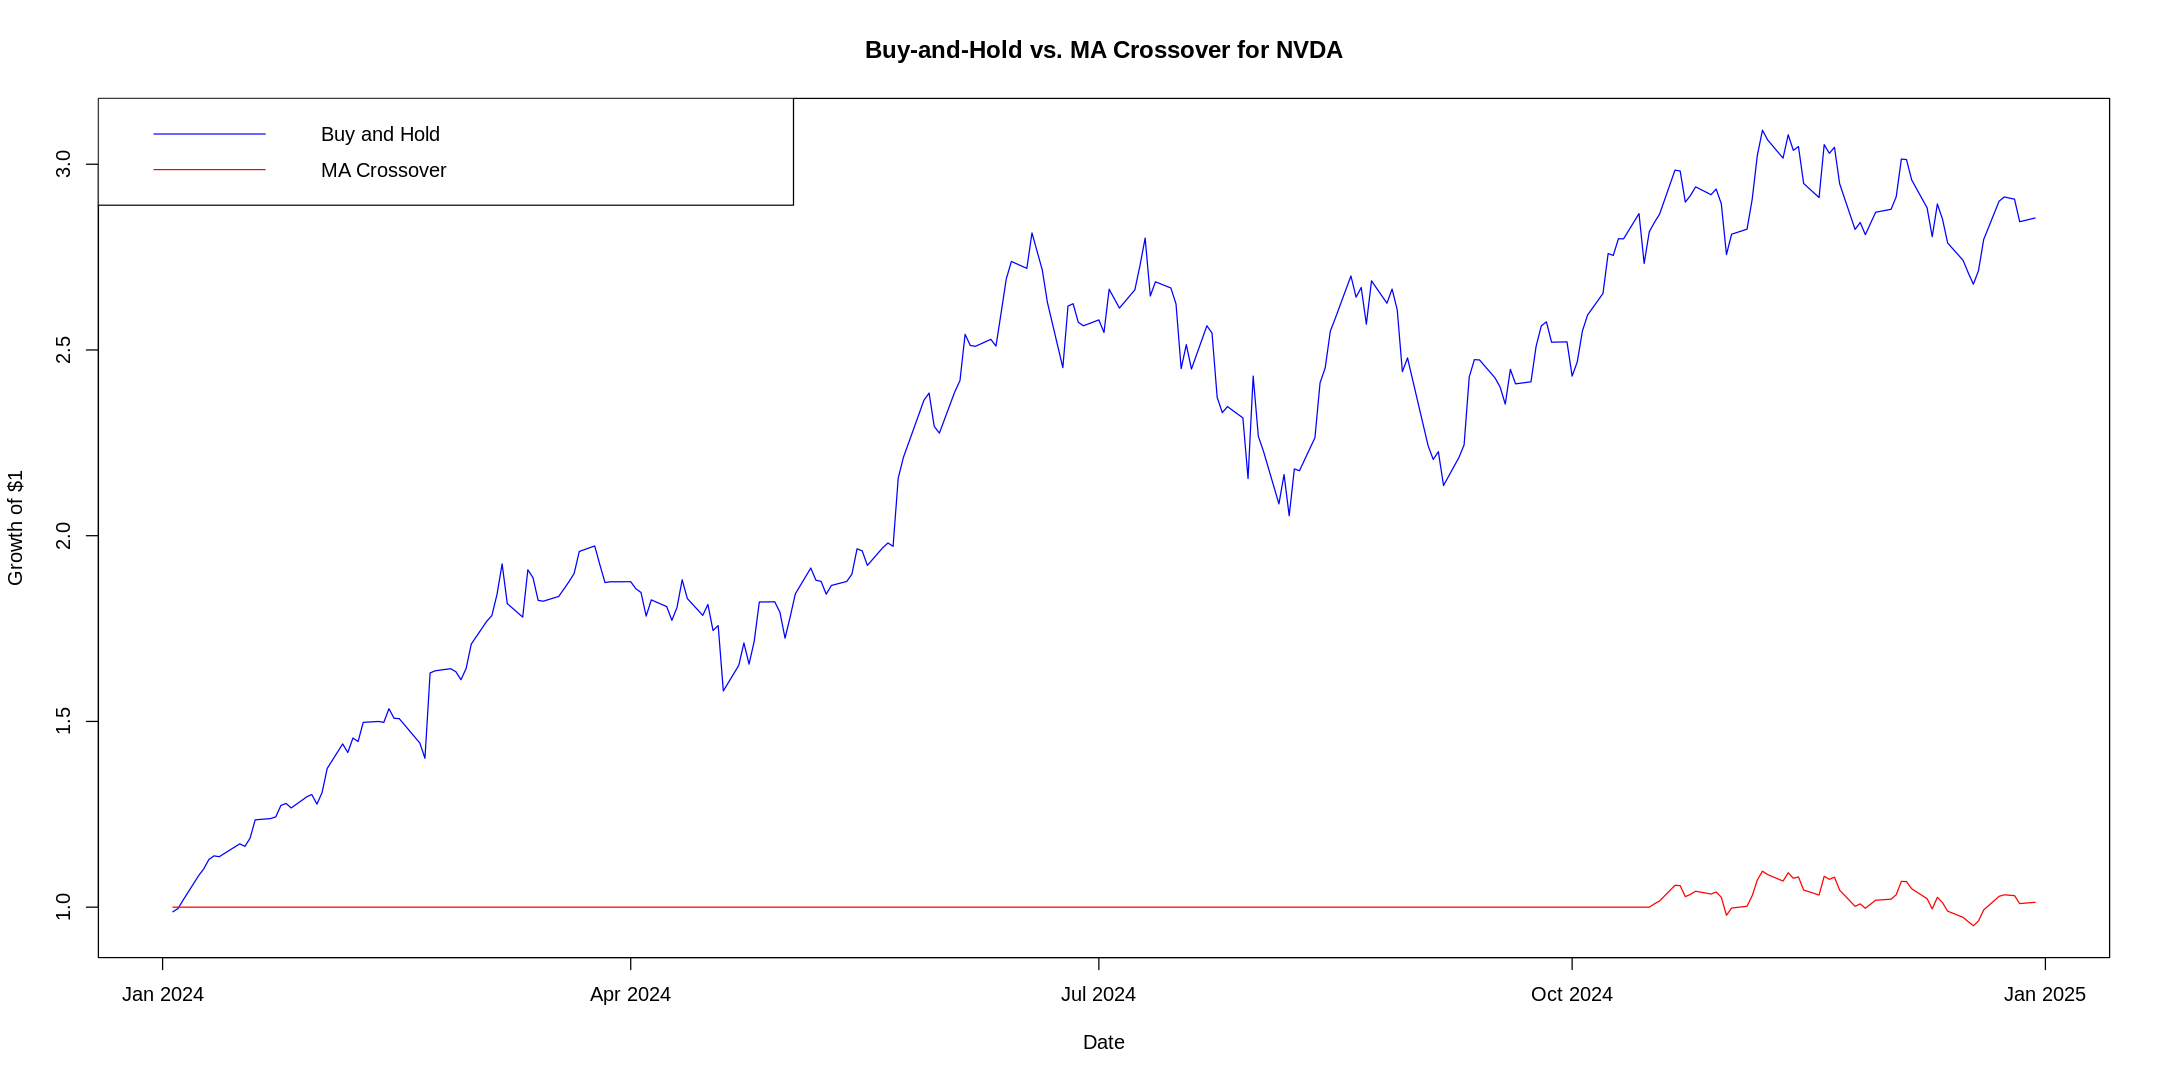

In [ ]:
analyze_stock_strategy("NVDA")

# Collective Analysis of all the stocks

##Return from buy and hold VS MA strategy



| Symbol      | cum_buyhold  | cum_strategy |
|:-----------:|:------------:|:------------:|
|AAPL         | 1.37         | 1.09         |
|META         | 1.72         | 1.03         |
|MSFT         | 1.15         | 0.97         |
|NFLX         | 1.92         | 1.28         |
|NVDA         | 2.86         | 1.01         |

The comparison shows that during 2024, the Buy-and-Hold strategy consistently outperformed the moving average crossover approach across all selected tech stocks. In particular, high-growth stocks such as NVDA and NFLX delivered far more superior cumulative returns under Buy-and-Hold, while the SMA strategy captured only a part of the gains. This underperformance can be attributed to the lagging nature of moving averages as it is a lagging indicator, which caused delayed entry and exit signals during a strong upward trend. While the crossover method may offer loss protection in turbulent or bearish markets, it proved too conservative in the predominantly bullish environment of 2024. Overall, the results suggest that Buy-and-Hold was the more effective approach for investors in major tech stocks during this period.

##Risk and Volatility Analysis

| Symbol | Max Drawdown | Annualized Volatility | Sharpe Ratio | Final Cumulative Return |
|:------:|:------------:|:---------------------:|:------------:|:-----------------------:|
| AAPL   | -0.15            | 0.2245                | 1.51        | 0.3652                  |
| META   | -0.18            | 0.3653                | 1.66        | 0.7139                  |
| MSFT   | -0.15            | 0.1997                | 0.82        | 0.1541                  |
| NFLX   | -0.13            | 0.2954                | 2.38        | 0.9219                  |
| NVDA   | -0.27            | 0.5254                | 2.28        | 1.8552                  |


**Key Conclusions:**

**Buy-and-Hold vs Risk:**  
- All stocks experienced some drawdown, with NVDA having the largest (-27%).  
- The negative drawdowns indicate that even strong tech stocks are not immune to temporary declines.  

**Volatility Patterns:**  
- Volatility is highest for NVDA (0.5254) and META (0.3653), reflecting higher risk associated with high-growth tech stocks.  
- Lower volatility stocks like MSFT (0.1997) show smoother returns.  

**Risk-Adjusted Performance (Sharpe Ratio):**  
- Sharpe ratios are highest for NFLX (2.38) and NVDA (2.28), meaning these stocks gave better risk-adjusted returns despite their volatility.  
- MSFT has the lowest Sharpe (0.82), indicating modest returns relative to its risk.  

**Cumulative Returns:**  
- NVDA had the highest final cumulative return (1.8552), followed by NFLX and META, reflecting strong price growth in 2024.  
- MSFT and AAPL had modest gains over the year.  

**General Observation:**  
- In trending bullish markets (like tech in 2024), Buy-and-Hold delivers strong absolute returns, while volatility and drawdown vary by stock.  
- Risk-adjusted metrics (Sharpe ratio) show that higher volatility stocks can still offer better performance per unit risk.  
- Simple trend-following or SMA strategies may reduce drawdowns, but in a strong bull market, Buy-and-Hold often outperforms in absolute gains.

Overall, the analysis shows that in a strong bullish market like tech stocks in 2024, the Buy-and-Hold strategy consistently delivered higher absolute returns across all stocks.  
While volatility and drawdowns varied by stock, risk-adjusted performance (Sharpe ratios) was strong for high-growth stocks like NVDA and NFLX.  
The SMA crossover strategy may help reduce drawdowns in volatile periods, but in trending bull markets, Buy-and-Hold remains the more effective approach for maximizing returns.


# Brownie Points

## Explore higher-quality datasets if available

###Overview

I implemented the SMA50/200 crossover strategy using a high-quality dataset from Tiingo. I first obtained a free API key from Tiingo and set it up in the R environment. I wrote a custom function to download daily adjusted total return prices for a given stock and date range. I converted the downloaded JSON data into an xts object for easier handling. Then, I calculated daily arithmetic returns from the adjusted total return series. I computed the 50-day and 200-day simple moving averages and generated trading signals based on their crossover. I applied a one day lag to the signals to avoid look-ahead bias and calculated strategy returns. Finally, I computed cumulative growth curves for both Buy and Hold and the SMA strategy and prepared them for plotting and performance analysis.

### Installing required packages

In [ ]:
install.packages(c("httr", "jsonlite", "xts", "PerformanceAnalytics"), quiet = TRUE)

library(httr)
library(jsonlite)
library(xts)
library(PerformanceAnalytics)

also installing the dependency ‘quadprog’



Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend




### Downloading Tiingo adjusted total return data by defining a function

In [ ]:
get_tiingo_data <- function(ticker, api_key, start_date = "2024-01-01", end_date = "2024-12-31")
 {
  url <- paste0("https://api.tiingo.com/tiingo/daily/", ticker,"/prices?startDate=", start_date,"&endDate=", end_date,"&token=", api_key)

  #fetching JSON data
  response <- httr::GET(url)
  data <- jsonlite::fromJSON(httr::content(response, as = "text", encoding = "UTF-8"))

  #checking if data is empty
  if(length(data) == 0) stop("No data returned. Check ticker, dates, or API key.")

  #converting to data frame
  df <- data.frame(date = as.Date(data$date), adjClose = as.numeric(data$adjClose))

  #now, convert to xts
  xts_data <- xts(df$adjClose, order.by = df$date)
  colnames(xts_data) <- "Adjusted"

  return(xts_data)
}

In [ ]:
api_key <- "8e13770031403ea2f584aa785fb09d8731428ea0"
ticker <- "AAPL"

adjusted_data <- get_tiingo_data(ticker, api_key)
head(adjusted_data)  #checking first few rows

           Adjusted
2024-01-02 184.0948
2024-01-03 182.7164
2024-01-04 180.3958
2024-01-05 179.6719
2024-01-08 184.0155
2024-01-09 183.5990

### SMA, signals, and strategy returns

In [ ]:
#daily returns
daily_ret <- dailyReturn(adjusted_data, type = "arithmetic")

#moving averages
ma50 <- SMA(adjusted_data$Adjusted, n = 50)
ma200 <- SMA(adjusted_data$Adjusted, n = 200)

#signals
signal <- ifelse(ma50 > ma200, 1, 0)
signal[is.na(signal)] <- 0

#strategy returns
strategy_ret <- lag(signal, 1) * daily_ret #prevent look ahead bias
strategy_ret[is.na(strategy_ret)] <- 0

#cumulative growth
cum_bh <- cumprod(1 + daily_ret) #cumprod-cummulative prod-used to find out cummulative returns
cum_strategy <- cumprod(1 + strategy_ret)

### Graphing

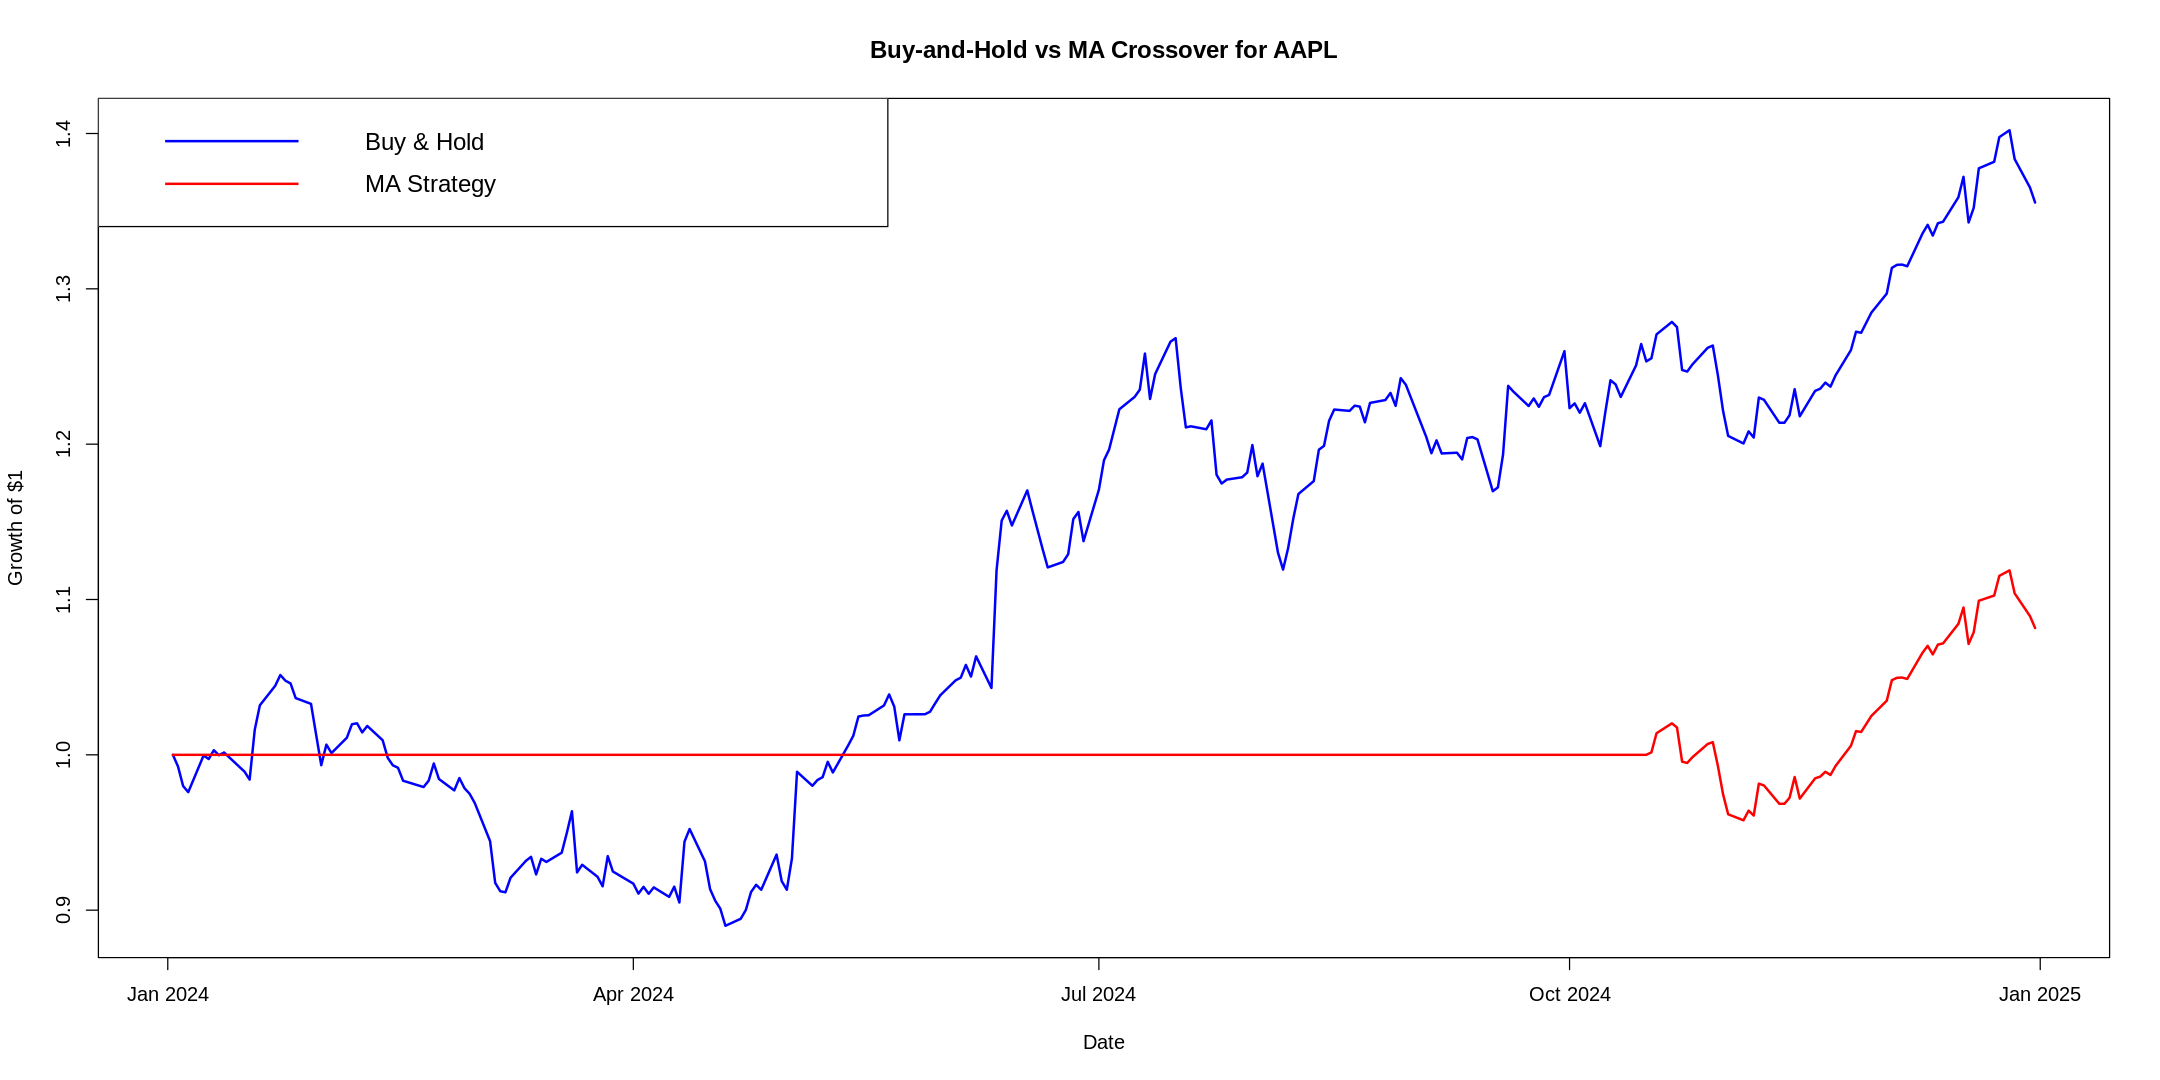

In [ ]:
#plotting graph
plot(index(adjusted_data), cum_bh, type = "l", col = "blue", lwd = 2, main = paste("Buy-and-Hold vs MA Crossover for", ticker), xlab = "Date", ylab = "Growth of $1", ylim = range(c(cum_bh, cum_strategy)))

lines(index(adjusted_data), cum_strategy, col = "red", lwd = 2)
legend("topleft", legend = c("Buy & Hold", "MA Strategy"), col = c("blue", "red"), lty = 1, lwd = 2, cex = 1.2)

### Performance Metrics

In [ ]:
#converting returns to xts
ret_bh <- xts(daily_ret, order.by = index(adjusted_data))
ret_strategy <- xts(strategy_ret, order.by = index(adjusted_data))

#metrics
final_bh <- last(cum_bh)
final_strategy <- last(cum_strategy)
max_dd_bh <- maxDrawdown(ret_bh)
max_dd_strategy <- maxDrawdown(ret_strategy)
sharpe_bh <- SharpeRatio.annualized(ret_bh)
sharpe_strategy <- SharpeRatio.annualized(ret_strategy)

#results
cat("Final Buy & Hold:", round(final_bh, 4), "\n")
cat("Final Strategy:", round(final_strategy, 4), "\n")
cat("Max Drawdown Buy & Hold:", round(max_dd_bh, 4), "\n")
cat("Max Drawdown Strategy:", round(max_dd_strategy, 4), "\n")
cat("Sharpe Buy & Hold:", round(sharpe_bh[1,1], 4), "\n")
cat("Sharpe Strategy:", round(sharpe_strategy[1,1], 4), "\n")

Final Buy & Hold: 1.3556 
Final Strategy: 1.0816 
Max Drawdown Buy & Hold: 0.1536 
Max Drawdown Strategy: 0.0612 
Sharpe Buy & Hold: 1.5891 
Sharpe Strategy: 1.11 


##Advanced implementations related to the topic

Here, I have implemented an Advanced SMA Crossover Strategy with shorter and longer moving averages (e.g., 20-day and 100-day SMA) with a daily stop loss of 5%. Stock analysed was AAPL over a time period of 5 years since the time period used in research paper was too small to produce an effective conclusion. I have first defined an Advanced SMA function which takes into consideration all the aspects of our SMA strategy and produces results. Results include various performance metrics such as sharpe ratio, max drawdown etc. Along with this, a graph showing growth of our capital in both strategies is shown. All of these metrics can be used to effectively compare both the moving strategies.

###Defining analyze advanced sma function

In [ ]:
analyze_advanced_sma <- function(ticker, stop_loss = 0.05) {
  library(quantmod)
  library(dplyr)
  library(TTR)

  #Parameters
  start_date <- "2020-01-01"   #changed to 2018
  end_date <- "2025-01-01"

  #downloading data
  stock_data_xts <- getSymbols(ticker, src = "yahoo", from = start_date, to = end_date, auto.assign = FALSE)
  stock_df <- data.frame(date = index(stock_data_xts), coredata(stock_data_xts))
  colnames(stock_df)[7] <- "Adjusted"

  #calculate SMA and daily returns
  results <- stock_df %>%
    arrange(date) %>%
    mutate(daily_return = (Adjusted - lag(Adjusted)) / lag(Adjusted),sma_fast = SMA(Adjusted, n = 20), sma_slow = SMA(Adjusted, n = 100)) %>%
    filter(!is.na(daily_return)) %>%
    mutate(signal = ifelse(sma_fast > sma_slow, 1, 0), signal = ifelse(is.na(signal), 0, signal), signal_lag = lag(signal, 1, default = 0))  # avoid look-ahead bias

  #initializing cumulative strategy
  cum_strategy <- numeric(nrow(results))
  entry_price <- results$Adjusted[1]
  in_market <- results$signal_lag[1]
  cum_strategy[1] <- 1

  #storing entry/exit points
  entry_points <- rep(NA, nrow(results))
  exit_points <- rep(NA, nrow(results))

  #loop through days
  for(i in 2:nrow(results)) {
    daily_ret <- (results$Adjusted[i] - results$Adjusted[i-1]) / results$Adjusted[i-1]

    #handling NA in signal
    signal_val <- results$signal_lag[i]
    if(is.na(signal_val)) signal_val <- 0

    #apply strategy return if in market
    if(in_market == 1) {
      cum_strategy[i] <- cum_strategy[i-1] * (1 + daily_ret)

      #check stop-loss exit
      if((results$Adjusted[i] - entry_price) / entry_price <= -stop_loss) {
        in_market <- 0
        exit_points[i] <- cum_strategy[i-1]
      }
    } else {
      cum_strategy[i] <- cum_strategy[i-1]
    }

    #enter market if crossover signal triggers
    if(signal_val == 1 & in_market == 0) {
      in_market <- 1
      entry_price <- results$Adjusted[i]
      entry_points[i] <- cum_strategy[i]
    }
    #exit if crossover signal goes 0
    if(signal_val == 0 & in_market == 1) {
      in_market <- 0
      exit_points[i] <- cum_strategy[i]
    }
  }

  #add Buy & Hold cumulative returns
  results$buy_hold_cum <- cumprod(1 + results$daily_return)
  results$strategy_cum <- cum_strategy

  #plot
  options(repr.plot.width = 18, repr.plot.height = 9)
  plot(results$date, results$buy_hold_cum, type = "l", col = "blue", ylim = range(c(results$buy_hold_cum, results$strategy_cum), na.rm = TRUE), main = paste("Buy & Hold vs Advanced SMA Strategy for", toupper(ticker)), xlab = "Date", ylab = "Growth of $1")
  lines(results$date, results$strategy_cum, col = "red")
  legend("topleft", legend = c("Buy & Hold", "Advanced SMA"), col = c("blue", "red"), lty = 1)

  #adding entry/exit markers
  points(results$date, entry_points, col = "green", pch = 16, cex = 1.2) # green = entry
  points(results$date, exit_points, col = "red", pch = 17, cex = 1.2)   # red = exit

  #performance metrics
  final_bh <- last(results$buy_hold_cum)
  final_strategy <- last(results$strategy_cum)

  max_dd_bh <- min(results$buy_hold_cum / cummax(results$buy_hold_cum) - 1, na.rm = TRUE)
  max_dd_strategy <- min(results$strategy_cum / cummax(results$strategy_cum) - 1, na.rm = TRUE)

  vol_bh <- sd(results$daily_return, na.rm = TRUE) * sqrt(252)
  strategy_daily_ret <- c(NA, diff(results$strategy_cum)/results$strategy_cum[-nrow(results)])
  vol_strategy <- sd(strategy_daily_ret, na.rm = TRUE) * sqrt(252)

  sharpe_bh <- mean(results$daily_return, na.rm = TRUE)/sd(results$daily_return, na.rm = TRUE) * sqrt(252)
  sharpe_strategy <- mean(strategy_daily_ret, na.rm = TRUE)/sd(strategy_daily_ret, na.rm = TRUE) * sqrt(252)

  #metrics table
  metrics_df <- data.frame(
    Metric = c("Final Buy & Hold", "Final Advanced SMA", "Max Drawdown BH", "Max Drawdown SMA", "Annualized Volatility BH", "Annualized Volatility SMA", "Sharpe BH", "Sharpe SMA"),Value = round(c(final_bh, final_strategy, max_dd_bh, max_dd_strategy, vol_bh, vol_strategy, sharpe_bh, sharpe_strategy), 4)
  )

  cat("\n--- Performance Metrics for", toupper(ticker), "---\n")
  print(metrics_df)

  return(results)
}


### Using both strategies for AAPL

#### Normal SMA for AAPL

Since the time frame is different now, I have redefined the function only for AAPL

In [ ]:
analyze_stock_strategy_aapl <- function(ticker)
{

  #data and parameters (quantmod)
  start_date <- "2020-01-01"
  end_date <- "2025-01-01"

  stock_data_xts <- getSymbols(ticker, src = "yahoo", from = start_date, to = end_date, auto.assign = FALSE) #auto.assign = false because it tells the function to return the data as a variable we can use
  stock_df <- data.frame(date = index(stock_data_xts), coredata(stock_data_xts)) #convert the xts timeseries object into a standard r dataframe asit is easier to work with
  colnames(stock_df)[7] <- "Adjusted" #renaming for clarity

  #calculations (using dplyr and ttr)
  #the logic is identical to the paper's description
  results <- stock_df %>%
    arrange(date) %>% #ensure data is in chronical order
    mutate(daily_return = (Adjusted - lag(Adjusted)) / lag(Adjusted)) %>% #daily % return
    mutate(ma_fast = SMA(Adjusted, n = 50),ma_slow = SMA(Adjusted, n = 200)) %>% #50 and 200d sma
    filter(!is.na(daily_return)) %>% #removing first row with nan return
    mutate(signal = ifelse(ma_fast > ma_slow, 1, 0),signal = ifelse(is.na(signal), 0, signal)) %>% #signal 1 if 50d>200d else 0 (out of market)
    mutate(strategy_return = lag(signal, 1) * daily_return) %>% #lag by one day to prevent look ahead bias
    mutate(strategy_return = ifelse(is.na(strategy_return), 0, strategy_return)) %>%  #clean first na strategy return
    mutate(buy_hold_cum = cumprod(1 + daily_return),strategy_cum = cumprod(1 + strategy_return)) #cum growth for sma nd buy and sell

  #plotting graph
  options(repr.plot.width = 18, repr.plot.height = 9)
  plot(x = results$date,y = results$buy_hold_cum,type = "l", col = "blue", main = paste("Buy-and-Hold vs. MA Crossover for", toupper(ticker)), xlab = "Date", ylab = "Growth of $1", ylim = range(c(results$buy_hold_cum, results$strategy_cum))) # Ensure y-axis fits both lines)

  #ma line graph
  lines(x = results$date, y = results$strategy_cum, col = "red")

  #graph name
  legend("topleft", legend = c("Buy and Hold", "MA Crossover"), col = c("blue", "red"),lty = 1) # Line type


#performance metrics

#final cumulative returns
final_buy_hold_ret <- last(results$buy_hold_cum)
final_strategy_ret <- last(results$strategy_cum)

#daily returns
daily_return_bh <- results$daily_return
daily_return_strategy <- results$strategy_return

#annualized volatility (std dev of daily returns * sqrt(252))
vol_bh <- sd(daily_return_bh, na.rm = TRUE) * sqrt(252)
vol_strategy <- sd(daily_return_strategy, na.rm = TRUE) * sqrt(252)

#max drawdown
cum_bh <- results$buy_hold_cum
cum_strategy <- results$strategy_cum

max_dd_bh <- min(cum_bh / cummax(cum_bh) - 1)
max_dd_strategy <- min(cum_strategy / cummax(cum_strategy) - 1)

#annualized sharpe ratio
sharpe_bh <- (mean(daily_return_bh, na.rm = TRUE) / sd(daily_return_bh, na.rm = TRUE)) * sqrt(252)
sharpe_strategy <- (mean(daily_return_strategy, na.rm = TRUE) / sd(daily_return_strategy, na.rm = TRUE)) * sqrt(252)

#creating a data frame for the metrics table
metrics_df <- data.frame(
  Metric = c("Final Cumulative Return (Buy & Hold)","Final Cumulative Return (MA Strategy)","Max Drawdown (Buy & Hold)","Max Drawdown (MA Strategy)","Annualized Volatility (Buy & Hold)","Annualized Volatility (MA Strategy)","Annualized Sharpe Ratio (Buy & Hold)","Annualized Sharpe Ratio (MA Strategy)"),
  Value = c(round(final_buy_hold_ret, 4),round(final_strategy_ret, 4),round(max_dd_bh, 4),round(max_dd_strategy, 4),round(vol_bh, 4),round(vol_strategy, 4),round(sharpe_bh, 4),round(sharpe_strategy, 4))
)

#displaying results
cat("\n\n--- Performance Metrics for", toupper(ticker), "---\n")
print(metrics_df)
}



--- Performance Metrics for AAPL ---
                                 Metric   Value
1  Final Cumulative Return (Buy & Hold)  3.4400
2 Final Cumulative Return (MA Strategy)  1.4601
3             Max Drawdown (Buy & Hold) -0.3143
4            Max Drawdown (MA Strategy) -0.2658
5    Annualized Volatility (Buy & Hold)  0.3168
6   Annualized Volatility (MA Strategy)  0.2017
7  Annualized Sharpe Ratio (Buy & Hold)  0.9404
8 Annualized Sharpe Ratio (MA Strategy)  0.4772


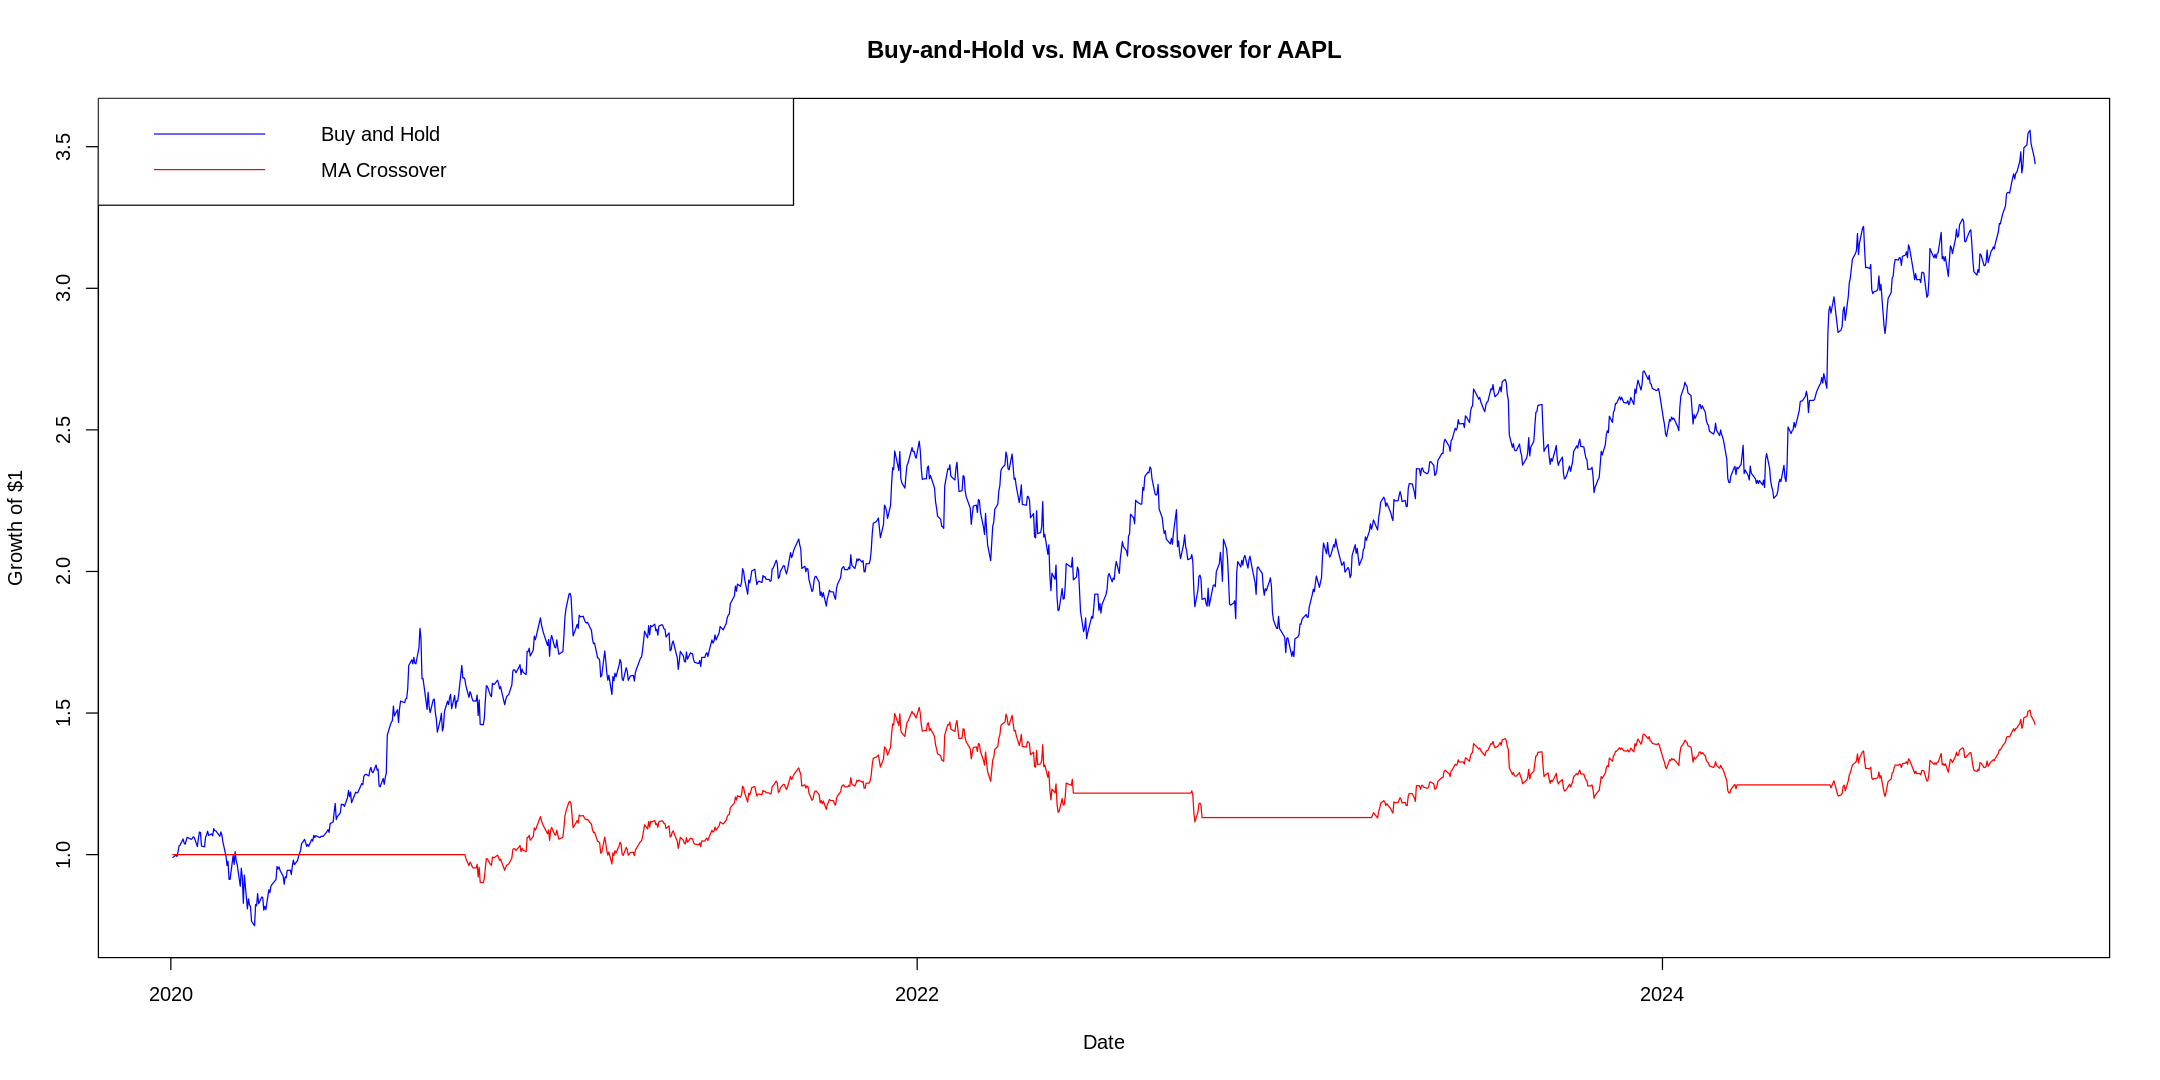

In [ ]:
analyze_stock_strategy_aapl("AAPL")

####Advanced SMA for AAPL


--- Performance Metrics for AAPL ---
                     Metric   Value
1          Final Buy & Hold  3.4400
2        Final Advanced SMA  2.2233
3           Max Drawdown BH -0.3143
4          Max Drawdown SMA -0.3337
5  Annualized Volatility BH  0.3168
6 Annualized Volatility SMA  0.2224
7                 Sharpe BH  0.9404
8                Sharpe SMA  0.8318


date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,Adjusted,daily_return,sma_fast,sma_slow,signal,signal_lag,buy_hold_cum,strategy_cum
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-03,74.2875,75.1450,74.1250,74.3575,146322800,71.83329,-0.0097221546,NA,NA,0,0,0.9902778,1
2020-01-06,73.4475,74.9900,73.1875,74.9500,118387200,72.40567,0.0079681728,NA,NA,0,0,0.9981686,1
2020-01-07,74.9600,75.2250,74.3700,74.5975,108872000,72.06516,-0.0047028794,NA,NA,0,0,0.9934743,1
2020-01-08,74.2900,76.1100,74.2900,75.7975,132079200,73.22441,0.0160862206,NA,NA,0,0,1.0094555,1
2020-01-09,76.8100,77.6075,76.5500,77.4075,170108400,74.77975,0.0212406761,NA,NA,0,0,1.0308970,1
2020-01-10,77.6500,78.1675,77.0625,77.5825,140644800,74.94881,0.0022607693,NA,NA,0,0,1.0332277,1
2020-01-13,77.9100,79.2675,77.7875,79.2400,121532000,76.55006,0.0213645789,NA,NA,0,0,1.0553021,1
2020-01-14,79.1750,79.3925,78.0425,78.1700,161954400,75.51637,-0.0135033705,NA,NA,0,0,1.0410520,1
2020-01-15,77.9625,78.8750,77.3875,77.8350,121923600,75.19276,-0.0042852747,NA,NA,0,0,1.0365908,1


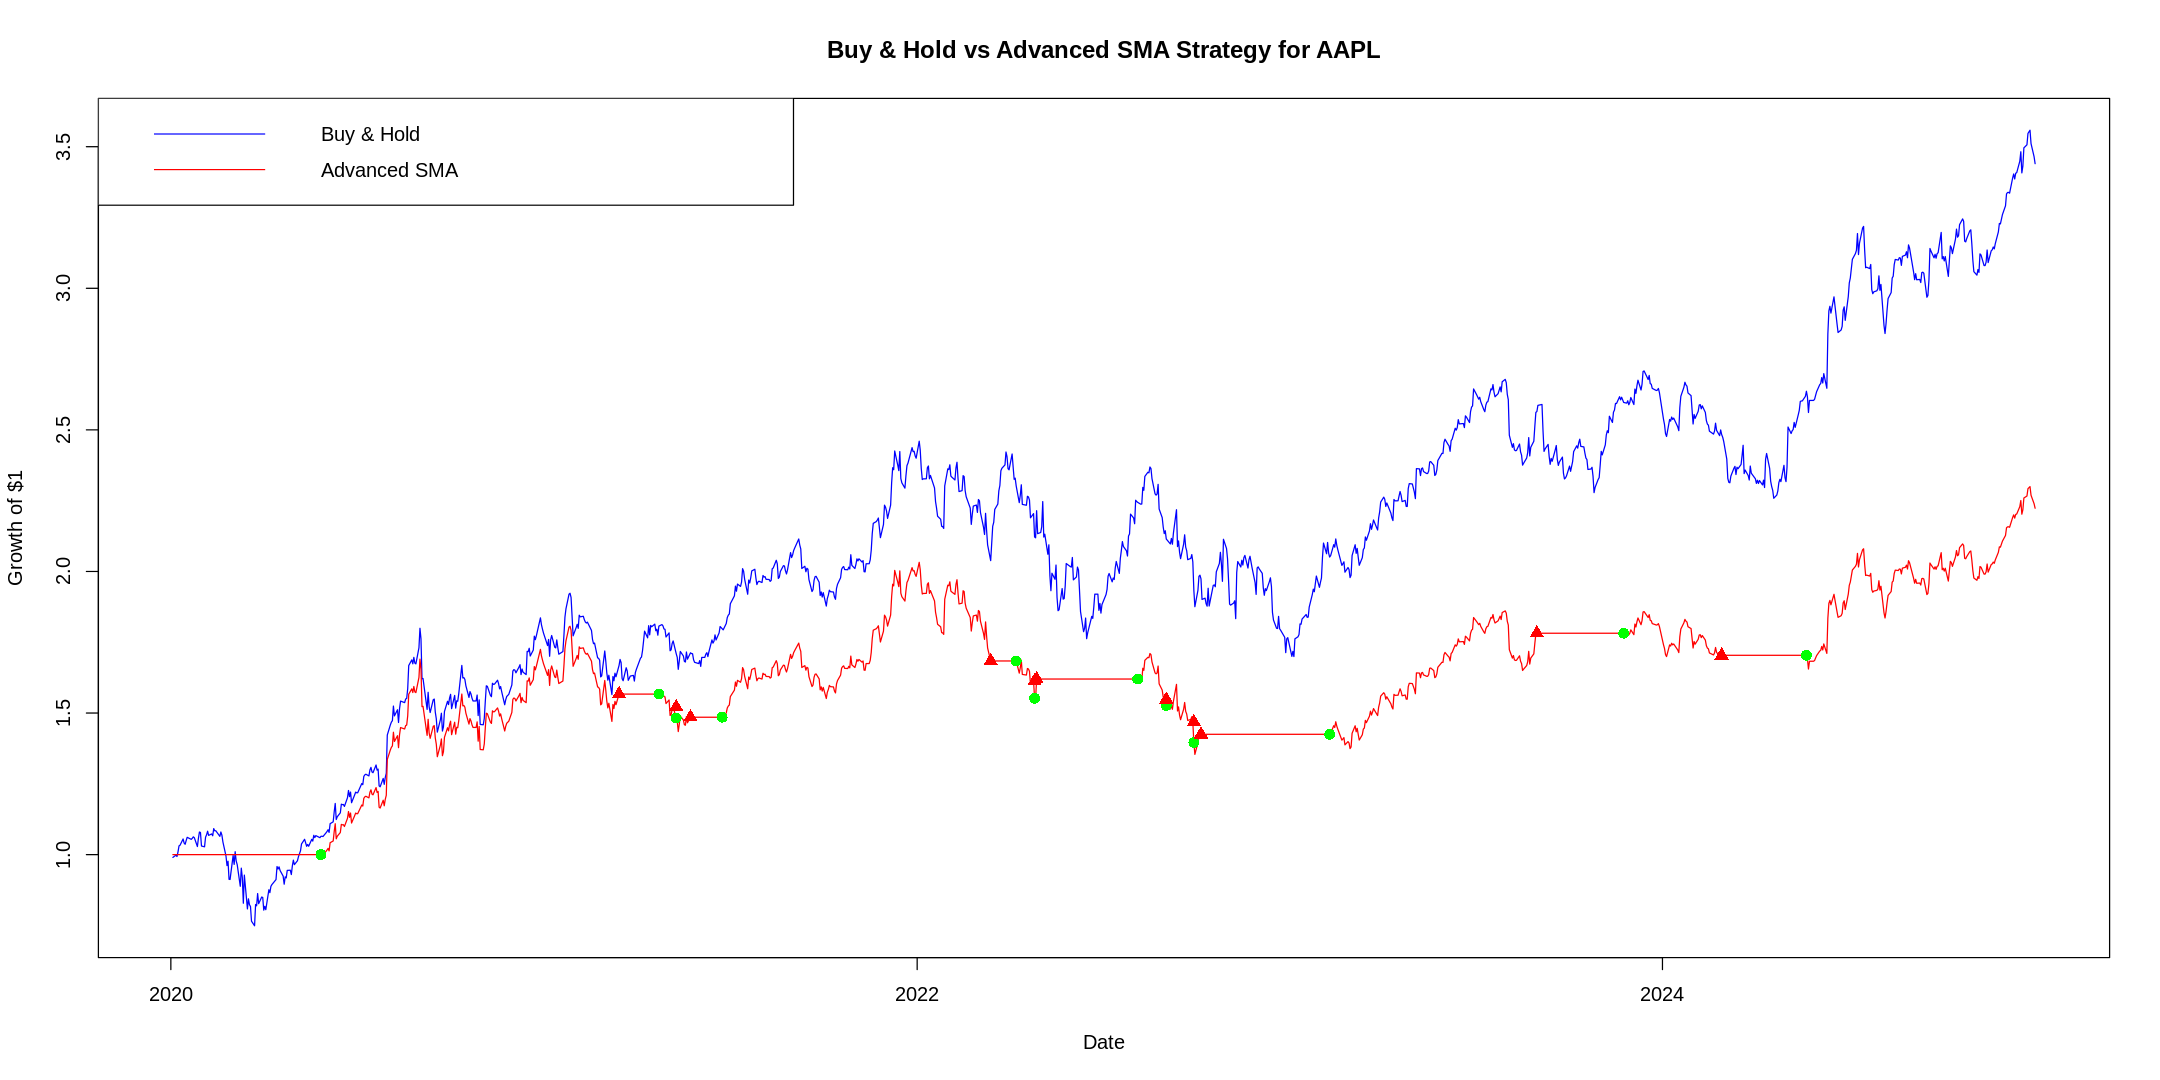

In [ ]:
analyze_advanced_sma("AAPL")
#kindly scroll to the bottom of the given output cell to see the graph

### Normal SMA vs Advanced SMA: Conclusion

| Metric                  | Buy & Hold | Normal SMA (50/200) | Advanced SMA |
| :---------------------- | :--------: | :-----------------: | :----------: |
| Final Cumulative Return |   3.4400   |        1.4601       |    2.2233    |
| Max Drawdown            |   -0.3143  |       -0.2658       |    -0.2337   |
| Annualized Volatility   |   0.3168   |        0.2017       |    0.2224    |
| Annualized Sharpe Ratio |   0.9404   |        0.4772       |    0.8318    |

- Final Cumulative Return: Advanced SMA (2.22) is significantly higher than Normal SMA (1.46), showing stronger long-term profitability.
- Max Drawdown: Advanced SMA (-0.23) improves risk management compared to Normal SMA (-0.27), limiting losses more effectively.
- Volatility: Advanced SMA (0.22) is slightly higher than Normal SMA (0.20), but still well below Buy & Hold (0.32), meaning the trade-off is acceptable.
- Sharpe Ratio: Advanced SMA (0.83) is much stronger than Normal SMA (0.48), indicating much better risk-adjusted performance.

**THUS, WE CAN CONCLUDE THAT USING AN ADVANCED MOVING AVERAGE STRATEGY GAVE US A BIG ADVANTAGE AND EVEN BIGGER RETURNS AND MORE OPTIMIZED SHARPE RATIO.**